In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp -r '/content/drive/My Drive/Colab Notebooks/[Kaggle] Understanding Clouds from Satellite Images/Scripts/.' .

In [0]:
!unzip -q '/content/drive/My Drive/Colab Notebooks/[Kaggle] Understanding Clouds from Satellite Images/Data/train_images320x480.zip'

### Dependencies

In [4]:
from utillity_script_cloud_segmentation import *
from utillity_script_lr_schedulers import *

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [0]:
seed = 0
seed_everything(seed)
warnings.filterwarnings("ignore")

In [0]:
#@title
class LRFinder(Callback):
    def __init__(self,
                 num_samples,
                 batch_size,
                 minimum_lr=1e-5,
                 maximum_lr=10.,
                 lr_scale='exp',
                 validation_data=None,
                 validation_sample_rate=5,
                 stopping_criterion_factor=4.,
                 loss_smoothing_beta=0.98,
                 save_dir=None,
                 verbose=True):
        """
        This class uses the Cyclic Learning Rate history to find a
        set of learning rates that can be good initializations for the
        One-Cycle training proposed by Leslie Smith in the paper referenced
        below.
        A port of the Fast.ai implementation for Keras.
        # Note
        This requires that the model be trained for exactly 1 epoch. If the model
        is trained for more epochs, then the metric calculations are only done for
        the first epoch.
        # Interpretation
        Upon visualizing the loss plot, check where the loss starts to increase
        rapidly. Choose a learning rate at somewhat prior to the corresponding
        position in the plot for faster convergence. This will be the maximum_lr lr.
        Choose the max value as this value when passing the `max_val` argument
        to OneCycleLR callback.
        Since the plot is in log-scale, you need to compute 10 ^ (-k) of the x-axis
        # Arguments:
            num_samples: Integer. Number of samples in the dataset.
            batch_size: Integer. Batch size during training.
            minimum_lr: Float. Initial learning rate (and the minimum).
            maximum_lr: Float. Final learning rate (and the maximum).
            lr_scale: Can be one of ['exp', 'linear']. Chooses the type of
                scaling for each update to the learning rate during subsequent
                batches. Choose 'exp' for large range and 'linear' for small range.
            validation_data: Requires the validation dataset as a tuple of
                (X, y) belonging to the validation set. If provided, will use the
                validation set to compute the loss metrics. Else uses the training
                batch loss. Will warn if not provided to alert the user.
            validation_sample_rate: Positive or Negative Integer. Number of batches to sample from the
                validation set per iteration of the LRFinder. Larger number of
                samples will reduce the variance but will take longer time to execute
                per batch.
                If Positive > 0, will sample from the validation dataset
                If Megative, will use the entire dataset
            stopping_criterion_factor: Integer or None. A factor which is used
                to measure large increase in the loss value during training.
                Since callbacks cannot stop training of a model, it will simply
                stop logging the additional values from the epochs after this
                stopping criterion has been met.
                If None, this check will not be performed.
            loss_smoothing_beta: Float. The smoothing factor for the moving
                average of the loss function.
            save_dir: Optional, String. If passed a directory path, the callback
                will save the running loss and learning rates to two separate numpy
                arrays inside this directory. If the directory in this path does not
                exist, they will be created.
            verbose: Whether to print the learning rate after every batch of training.
        # References:
            - [A disciplined approach to neural network hyper-parameters: Part 1 -- learning rate, batch size, weight_decay, and weight decay](https://arxiv.org/abs/1803.09820)
        """
        super(LRFinder, self).__init__()

        if lr_scale not in ['exp', 'linear']:
            raise ValueError("`lr_scale` must be one of ['exp', 'linear']")

        if validation_data is not None:
            self.validation_data = validation_data
            self.use_validation_set = True

            if validation_sample_rate > 0 or validation_sample_rate < 0:
                self.validation_sample_rate = validation_sample_rate
            else:
                raise ValueError("`validation_sample_rate` must be a positive or negative integer other than o")
        else:
            self.use_validation_set = False
            self.validation_sample_rate = 0

        self.num_samples = num_samples
        self.batch_size = batch_size
        self.initial_lr = minimum_lr
        self.final_lr = maximum_lr
        self.lr_scale = lr_scale
        self.stopping_criterion_factor = stopping_criterion_factor
        self.loss_smoothing_beta = loss_smoothing_beta
        self.save_dir = save_dir
        self.verbose = verbose

        self.num_batches_ = num_samples // batch_size
        self.current_lr_ = minimum_lr

        if lr_scale == 'exp':
            self.lr_multiplier_ = (maximum_lr / float(minimum_lr)) ** (
                1. / float(self.num_batches_))
        else:
            extra_batch = int((num_samples % batch_size) != 0)
            self.lr_multiplier_ = np.linspace(
                minimum_lr, maximum_lr, num=self.num_batches_ + extra_batch)

        # If negative, use entire validation set
        if self.validation_sample_rate < 0:
            self.validation_sample_rate = self.validation_data[0].shape[0] // batch_size

        self.current_batch_ = 0
        self.current_epoch_ = 0
        self.best_loss_ = 1e6
        self.running_loss_ = 0.

        self.history = {}

    def on_train_begin(self, logs=None):

        self.current_epoch_ = 1
        K.set_value(self.model.optimizer.lr, self.initial_lr)

        warnings.simplefilter("ignore")

    def on_epoch_begin(self, epoch, logs=None):
        self.current_batch_ = 0

        if self.current_epoch_ > 1:
            warnings.warn(
                "\n\nLearning rate finder should be used only with a single epoch. "
                "Hereafter, the callback will not measure the losses.\n\n")

    def on_batch_begin(self, batch, logs=None):
        self.current_batch_ += 1

    def on_batch_end(self, batch, logs=None):
        if self.current_epoch_ > 1:
            return

        if self.use_validation_set:
            X, Y = self.validation_data[0], self.validation_data[1]

            # use 5 random batches from test set for fast approximate of loss
            num_samples = self.batch_size * self.validation_sample_rate

            if num_samples > X.shape[0]:
                num_samples = X.shape[0]

            idx = np.random.choice(X.shape[0], num_samples, replace=False)
            x = X[idx]
            y = Y[idx]

            values = self.model.evaluate(x, y, batch_size=self.batch_size, verbose=False)
            loss = values[0]
        else:
            loss = logs['loss']

        # smooth the loss value and bias correct
        running_loss = self.loss_smoothing_beta * loss + (
            1. - self.loss_smoothing_beta) * loss
        running_loss = running_loss / (
            1. - self.loss_smoothing_beta**self.current_batch_)

        # stop logging if loss is too large
        if self.current_batch_ > 1 and self.stopping_criterion_factor is not None and (
                running_loss >
                self.stopping_criterion_factor * self.best_loss_):

            if self.verbose:
                print(" - LRFinder: Skipping iteration since loss is %d times as large as best loss (%0.4f)"
                      % (self.stopping_criterion_factor, self.best_loss_))
            return

        if running_loss < self.best_loss_ or self.current_batch_ == 1:
            self.best_loss_ = running_loss

        current_lr = K.get_value(self.model.optimizer.lr)

        self.history.setdefault('running_loss_', []).append(running_loss)
        if self.lr_scale == 'exp':
            self.history.setdefault('log_lrs', []).append(np.log10(current_lr))
        else:
            self.history.setdefault('log_lrs', []).append(current_lr)

        # compute the lr for the next batch and update the optimizer lr
        if self.lr_scale == 'exp':
            current_lr *= self.lr_multiplier_
        else:
            current_lr = self.lr_multiplier_[self.current_batch_ - 1]

        K.set_value(self.model.optimizer.lr, current_lr)

        # save the other metrics as well
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        if self.verbose:
            if self.use_validation_set:
                print(" - LRFinder: val_loss: %1.4f - lr = %1.8f " %
                      (values[0], current_lr))
            else:
                print(" - LRFinder: lr = %1.8f " % current_lr)

    def on_epoch_end(self, epoch, logs=None):
        if self.save_dir is not None and self.current_epoch_ <= 1:
            if not os.path.exists(self.save_dir):
                os.makedirs(self.save_dir)

            losses_path = os.path.join(self.save_dir, 'losses.npy')
            lrs_path = os.path.join(self.save_dir, 'lrs.npy')

            np.save(losses_path, self.losses)
            np.save(lrs_path, self.lrs)

            if self.verbose:
                print("\tLR Finder : Saved the losses and learning rate values in path : {%s}"
                      % (self.save_dir))

        self.current_epoch_ += 1

        warnings.simplefilter("default")

    def plot_schedule(self, clip_beginning=None, clip_endding=None):
        """
        Plots the schedule from the callback itself.
        # Arguments:
            clip_beginning: Integer or None. If positive integer, it will
                remove the specified portion of the loss graph to remove the large
                loss values in the beginning of the graph.
            clip_endding: Integer or None. If negative integer, it will
                remove the specified portion of the ending of the loss graph to
                remove the sharp increase in the loss values at high learning rates.
        """
        try:
            import matplotlib.pyplot as plt
            plt.style.use('seaborn-white')
        except ImportError:
            print(
                "Matplotlib not found. Please use `pip install matplotlib` first."
            )
            return

        if clip_beginning is not None and clip_beginning < 0:
            clip_beginning = -clip_beginning

        if clip_endding is not None and clip_endding > 0:
            clip_endding = -clip_endding

        losses = self.losses
        lrs = self.lrs

        if clip_beginning:
            losses = losses[clip_beginning:]
            lrs = lrs[clip_beginning:]

        if clip_endding:
            losses = losses[:clip_endding]
            lrs = lrs[:clip_endding]

        plt.plot(lrs, losses)
        plt.title('Learning rate vs Loss')
        plt.xlabel('learning rate')
        plt.ylabel('loss')
        plt.show()

    @classmethod
    def restore_schedule_from_dir(cls,
                                  directory,
                                  clip_beginning=None,
                                  clip_endding=None):
        """
        Loads the training history from the saved numpy files in the given directory.
        # Arguments:
            directory: String. Path to the directory where the serialized numpy
                arrays of the loss and learning rates are saved.
            clip_beginning: Integer or None. If positive integer, it will
                remove the specified portion of the loss graph to remove the large
                loss values in the beginning of the graph.
            clip_endding: Integer or None. If negative integer, it will
                remove the specified portion of the ending of the loss graph to
                remove the sharp increase in the loss values at high learning rates.
        Returns:
            tuple of (losses, learning rates)
        """
        if clip_beginning is not None and clip_beginning < 0:
            clip_beginning = -clip_beginning

        if clip_endding is not None and clip_endding > 0:
            clip_endding = -clip_endding

        losses_path = os.path.join(directory, 'losses.npy')
        lrs_path = os.path.join(directory, 'lrs.npy')

        if not os.path.exists(losses_path) or not os.path.exists(lrs_path):
            print("%s and %s could not be found at directory : {%s}" %
                  (losses_path, lrs_path, directory))

            losses = None
            lrs = None

        else:
            losses = np.load(losses_path)
            lrs = np.load(lrs_path)

            if clip_beginning:
                losses = losses[clip_beginning:]
                lrs = lrs[clip_beginning:]

            if clip_endding:
                losses = losses[:clip_endding]
                lrs = lrs[:clip_endding]

        return losses, lrs

    @classmethod
    def plot_schedule_from_file(cls,
                                directory,
                                clip_beginning=None,
                                clip_endding=None):
        """
        Plots the schedule from the saved numpy arrays of the loss and learning
        rate values in the specified directory.
        # Arguments:
            directory: String. Path to the directory where the serialized numpy
                arrays of the loss and learning rates are saved.
            clip_beginning: Integer or None. If positive integer, it will
                remove the specified portion of the loss graph to remove the large
                loss values in the beginning of the graph.
            clip_endding: Integer or None. If negative integer, it will
                remove the specified portion of the ending of the loss graph to
                remove the sharp increase in the loss values at high learning rates.
        """
        try:
            import matplotlib.pyplot as plt
            plt.style.use('seaborn-white')
        except ImportError:
            print("Matplotlib not found. Please use `pip install matplotlib` first.")
            return

        losses, lrs = cls.restore_schedule_from_dir(
            directory,
            clip_beginning=clip_beginning,
            clip_endding=clip_endding)

        if losses is None or lrs is None:
            return
        else:
            plt.plot(lrs, losses)
            plt.title('Learning rate vs Loss')
            plt.xlabel('learning rate')
            plt.ylabel('loss')
            plt.show()

    @property
    def lrs(self):
        return np.array(self.history['log_lrs'])

    @property
    def losses(self):
        return np.array(self.history['running_loss_'])

In [0]:
base_path = '/content/drive/My Drive/Colab Notebooks/[Kaggle] Understanding Clouds from Satellite Images/'
data_path = base_path + 'Data/'
model_base_path = base_path + 'Models/files/classification/'
train_path = data_path + 'train.csv'
hold_out_set_path = data_path + 'hold-out.csv'
train_images_dest_path = 'train_images/'

### Load data

In [8]:
train = pd.read_csv(train_path)
hold_out_set = pd.read_csv(hold_out_set_path)

X_train = hold_out_set[hold_out_set['set'] == 'train']
X_val = hold_out_set[hold_out_set['set'] == 'validation']

print('Compete set samples:', len(train))
print('Train samples: ', len(X_train))
print('Validation samples: ', len(X_val))

# Preprocecss data
train['image'] = train['Image_Label'].apply(lambda x: x.split('_')[0])
label_columns=['Fish', 'Flower', 'Gravel', 'Sugar']
for label in label_columns:
  X_train[label].replace({0: 1, 1: 0}, inplace=True)
  X_val[label].replace({0: 1, 1: 0}, inplace=True)

display(X_train.head())

Compete set samples: 22184
Train samples:  4420
Validation samples:  1105


,image,Fish_mask,Flower_mask,Gravel_mask,Sugar_mask,Fish,Flower,Gravel,Sugar,set
0,1f3d231.jpg,NaN,1625401 196 1625598 4 1625607 1 1625612 5 1625...,NaN,NaN,1,0,1,1,train
1,0fa3287.jpg,NaN,121884 511 123284 511 124684 511 126084 511 12...,NaN,32739 369 34139 369 35539 369 36939 369 38339 ...,1,0,1,0,train
2,4d17338.jpg,64 1141 1464 1141 2864 1141 4264 1141 5664 114...,NaN,NaN,13141 707 14541 707 15941 707 17341 707 18741 ...,0,1,1,0,train
3,12e55a8.jpg,NaN,1187509 1060 1188909 1060 1190309 1060 1191709...,NaN,2808 614 4208 614 5608 614 7008 614 8408 614 9...,1,0,1,0,train
4,697eb53.jpg,52180 1006 53580 1006 54980 1006 56380 1006 57...,NaN,NaN,NaN,0,1,1,1,train


# Model parameters

In [0]:
BATCH_SIZE = 16
WARMUP_EPOCHS = 3
WARMUP_LEARNING_RATE = 1e-3
EPOCHS = 30
BASE_LEARNING_RATE = 10**(-5.6)
LEARNING_RATE = 10**(-2)
HEIGHT = 300
WIDTH = 300
CHANNELS = 3
N_CLASSES = 4
ES_PATIENCE = 8
STEP_SIZE_TRAIN = len(X_train)//BATCH_SIZE
STEP_SIZE_VALID = len(X_val)//BATCH_SIZE
CYCLE_SIZE = 6
STEP_SIZE = (CYCLE_SIZE // 2) * STEP_SIZE_TRAIN

model_name = '23-EfficientNetB3_%sx%s' % (HEIGHT, WIDTH)
model_path = model_base_path + '%s.h5' % (model_name)

### Data generator

In [33]:
datagen=ImageDataGenerator(rescale=1./255.,
                           vertical_flip=True,
                           horizontal_flip=True,
                           zoom_range=[1, 1.1],
                           fill_mode='constant',
                           cval=0.)

test_datagen=ImageDataGenerator(rescale=1./255.)

train_generator=datagen.flow_from_dataframe(
                        dataframe=X_train,
                        directory=train_images_dest_path,
                        x_col="image",
                        y_col=label_columns,
                        target_size=(HEIGHT, WIDTH),
                        batch_size=BATCH_SIZE,
                        class_mode="other",
                        shuffle=True,
                        seed=seed)

valid_generator=test_datagen.flow_from_dataframe(
                             dataframe=X_val,
                             directory=train_images_dest_path,
                             x_col="image",
                             y_col=label_columns,
                             target_size=(HEIGHT, WIDTH),
                             batch_size=BATCH_SIZE,
                             class_mode="other",
                             shuffle=True,
                             seed=seed)

Found 4420 validated image filenames.
Found 1105 validated image filenames.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:656: DeprecationWarning: `class_mode` "other" is deprecated, please use `class_mode` "raw".
  '`class_mode` "raw".', DeprecationWarning)


# Model

In [0]:
def create_model(input_shape, N_CLASSES):
    input_tensor = Input(shape=input_shape)
    base_model = efn.EfficientNetB3(weights='imagenet', 
                                    include_top=False,
                                    input_tensor=input_tensor, 
                                    pooling='avg')

    x = base_model.output
    final_output = Dense(N_CLASSES, activation='sigmoid')(x)
    model = Model(input_tensor, final_output)
    
    return model

## Warmup top layers

In [0]:
model = create_model((None, None, CHANNELS), N_CLASSES)
metric_list = ['accuracy']

for layer in model.layers[:-1]:
  layer.trainable = False

optimizer = optimizers.SGD(lr=WARMUP_LEARNING_RATE, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metric_list)

In [36]:
warmup_history = model.fit_generator(generator=train_generator,
                                      steps_per_epoch=STEP_SIZE_TRAIN,
                                      validation_data=valid_generator,
                                      validation_steps=STEP_SIZE_VALID,
                                      epochs=WARMUP_EPOCHS,
                                      verbose=1).history

Epoch 1/3
276/276 [==============================] - 94s 340ms/step - loss: 0.6740 - acc: 0.5793 - val_loss: 0.7002 - val_acc: 0.5700
Epoch 2/3
276/276 [==============================] - 82s 296ms/step - loss: 0.6519 - acc: 0.6240 - val_loss: 0.7056 - val_acc: 0.5700
Epoch 3/3
276/276 [==============================] - 81s 295ms/step - loss: 0.6412 - acc: 0.6377 - val_loss: 0.7068 - val_acc: 0.5700


In [0]:
for layer in model.layers:
    layer.trainable = True
    
warm_weights = model.get_weights()

# Learning rate finder

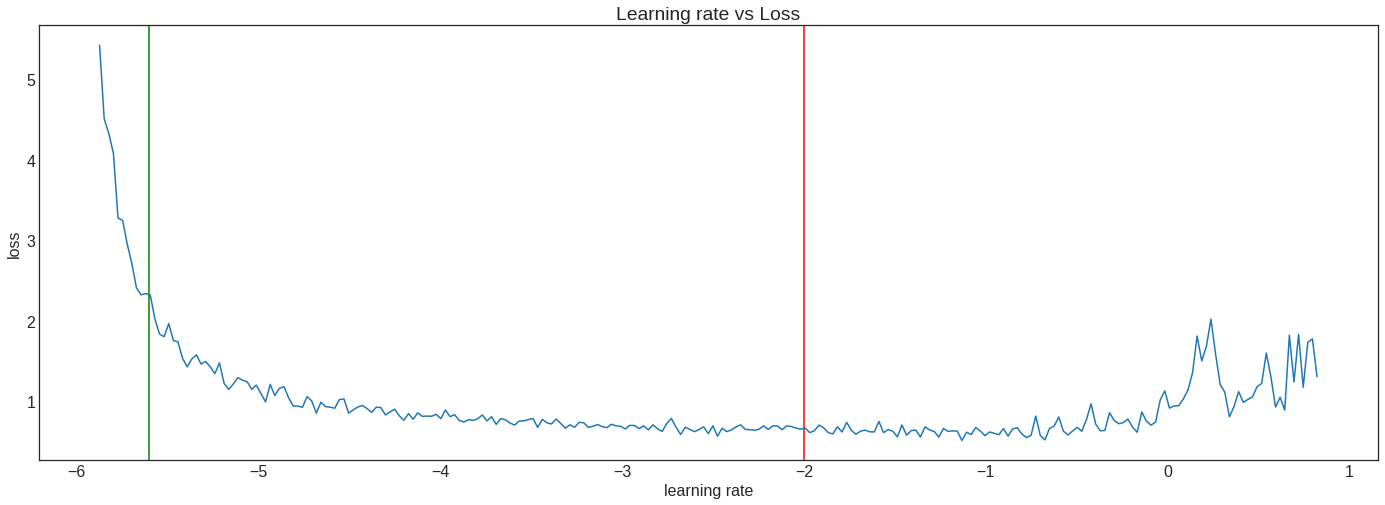

In [40]:
#@title
lr_finder = LRFinder(num_samples=len(X_train), batch_size=BATCH_SIZE, minimum_lr=1e-6, maximum_lr=10, verbose=0)

optimizer = optimizers.SGD(lr=WARMUP_LEARNING_RATE, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss='binary_crossentropy')

history = model.fit_generator(generator=train_generator, 
                              steps_per_epoch=STEP_SIZE_TRAIN, 
                              epochs=1, 
                              callbacks=[lr_finder])

plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(24, 8))
plt.axvline(x=np.log10(BASE_LEARNING_RATE), color='green')
plt.axvline(x=np.log10(LEARNING_RATE), color='red')
lr_finder.plot_schedule(clip_beginning=5)

## Fine-tune all layers

In [0]:
model.set_weights(warm_weights)

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
cyclicalLR = CyclicLR(base_lr=BASE_LEARNING_RATE, max_lr=LEARNING_RATE, step_size=STEP_SIZE, mode='triangular')

callback_list = [checkpoint, es, cyclicalLR]

optimizer = optimizers.SGD(lr=LEARNING_RATE, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metric_list)

In [42]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              callbacks=callback_list,
                              epochs=EPOCHS,
                              verbose=1).history

Epoch 1/30
  2/276 [..............................] - ETA: 45:28 - loss: 0.6397 - acc: 0.6719  

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (1.066931). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


276/276 [==============================] - 146s 528ms/step - loss: 0.6188 - acc: 0.6628 - val_loss: 0.7749 - val_acc: 0.4413
Epoch 2/30
276/276 [==============================] - 123s 446ms/step - loss: 0.5678 - acc: 0.7023 - val_loss: 0.5586 - val_acc: 0.7156
Epoch 3/30
276/276 [==============================] - 124s 448ms/step - loss: 0.5384 - acc: 0.7240 - val_loss: 0.5306 - val_acc: 0.7257
Epoch 4/30
276/276 [==============================] - 123s 446ms/step - loss: 0.5110 - acc: 0.7442 - val_loss: 0.5143 - val_acc: 0.7408
Epoch 5/30
276/276 [==============================] - 123s 446ms/step - loss: 0.4891 - acc: 0.7594 - val_loss: 0.5118 - val_acc: 0.7358
Epoch 6/30
276/276 [==============================] - 124s 450ms/step - loss: 0.4732 - acc: 0.7700 - val_loss: 0.4988 - val_acc: 0.7484
Epoch 7/30
276/276 [==============================] - 124s 449ms/step - loss: 0.4680 - acc: 0.7754 - val_loss: 0.4971 - val_acc: 0.7551
Epoch 8/30
276/276 [==============================] - 123s 

## Model loss graph

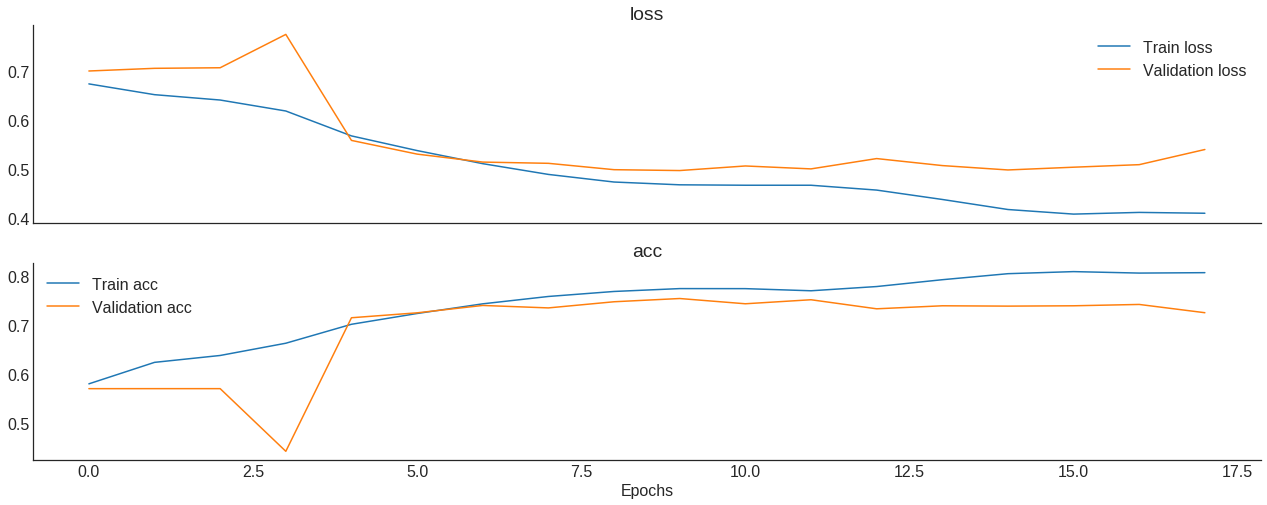

In [43]:
#@title
metrics_history = ['loss', 'acc']
for metric_hist in metrics_history:
  history[metric_hist] = warmup_history[metric_hist] + history[metric_hist]
  history['val_' + metric_hist] = warmup_history['val_' + metric_hist] + history['val_' + metric_hist]

plot_metrics(history, metric_list=metrics_history)

## Scheduler learning rates

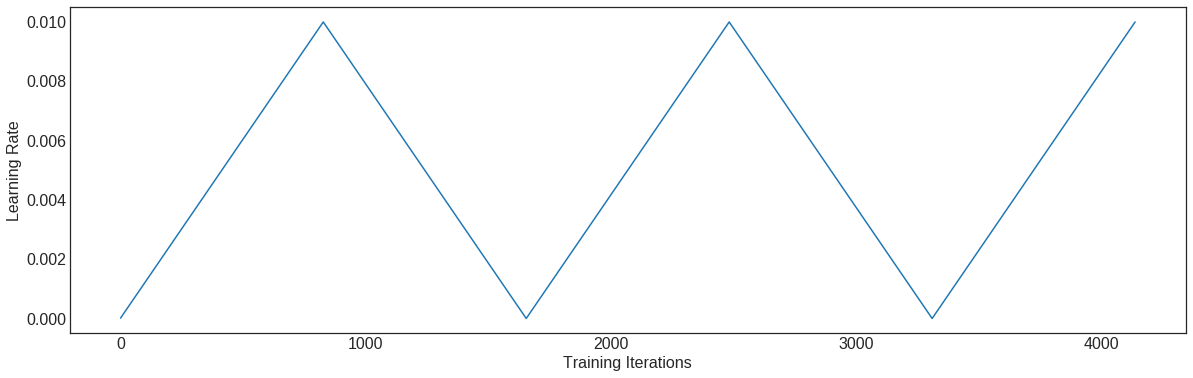

In [44]:
#@title
fig, ax1 = plt.subplots(1, 1, figsize=(20, 6))

plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.plot(cyclicalLR.history['lr'])
plt.show()